## Import necessary libraries


In [100]:
import pandas as pd

## Data Ingestion and Exploration
Load data

In [101]:
email_data = pd.read_csv('gs://spam-detection-data-bucket/input/spam.csv')

In [102]:
email_data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [103]:
email_data.shape

(5572, 2)

In [104]:
# replace ham with 0 and spam with 1 in the Category column
email_data['Category']=email_data.Category.apply(lambda x: 1 if x=="spam" else 0)

In [105]:
email_data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [106]:
email_data.drop_duplicates(inplace=True)

In [107]:
# shape after dropping duplicates
email_data.shape

(5157, 2)

In [108]:
email_data['Category'].value_counts()

0    4516
1     641
Name: Category, dtype: int64

<AxesSubplot:>

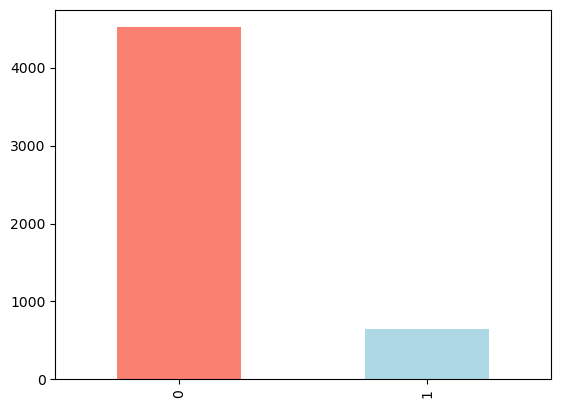

In [109]:
# A plot to show the labels value count
email_data.Category.value_counts().plot(kind="bar", color=["salmon", "lightblue"])

#### This plot shows that the labels are heavily imbalanced.

## Data Preprocessing

#### Perform a combination of random oversampling and undersampling to balance the data.

In [110]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [111]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [112]:
# Separate features (X) and labels (y)
X = email_data.drop('Category', axis=1)
y = email_data['Category']

In [113]:
# Print class distribution before sampling
print("Class distribution before sampling:")
print(email_data['Category'].value_counts())

Class distribution before sampling:
0    4516
1     641
Name: Category, dtype: int64


In [114]:
# Apply oversampling
oversampler = RandomOverSampler(sampling_strategy=0.5)
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

In [115]:
# Apply undersampling
undersampler = RandomUnderSampler(sampling_strategy=0.9)
X_sampled, y_sampled = undersampler.fit_resample(X_oversampled, y_oversampled)

In [116]:
# Create a new DataFrame with the sampled data
sampled_data = pd.concat([X_sampled, y_sampled], axis=1)

In [117]:
# Print class distribution after sampling
print("Class distribution after sampling:")
print(sampled_data['Category'].value_counts())

Class distribution after sampling:
0    2508
1    2258
Name: Category, dtype: int64


In [118]:
sampled_data.sample(5)

,Message,Category
1034,What i mean is do they come chase you out when...,0
3219,Rock yr chik. Get 100's of filthy films &XXX p...,1
950,Just taste fish curry :-P,0
1788,I'm going for bath will msg you next &lt;#&gt...,0
3356,Win the newest Harry Potter and the Order of ...,1


In [119]:
sampled_data.shape

(4766, 2)

<AxesSubplot:>

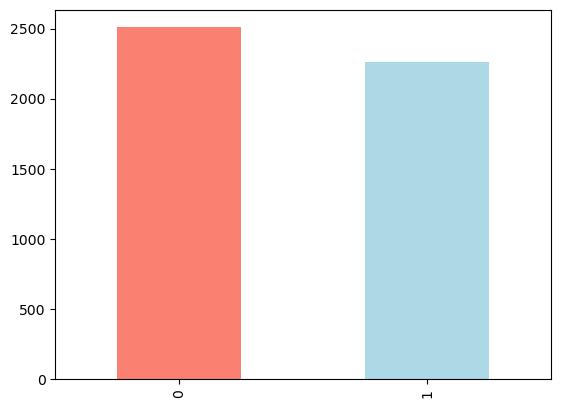

In [120]:
# New plot to show the labels value count
sampled_data.Category.value_counts().plot(kind="bar", color=["salmon", "lightblue"])

## Natural Language Processing operations

In [186]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

In [187]:
def transform_text(text):
    text = text.lower()
    words = nltk.word_tokenize(text)
    
    filtered_words = [word for word in words if word.isalnum() and word not in stopwords.words('english') and word not in string.punctuation]
    
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    
    return " ".join(stemmed_words)


In [208]:
sampled_data['Transformed_emails'] = sampled_data['Message'].apply(lambda text: transform_text(text))

## Data Anonymization

In [191]:
# anonymization
import re

# Define the masking function
def mask_sensitive_info(text):
    # Define regular expressions for patterns to mask
    patterns = {
        'PERSON': r'\b[A-Z][a-z]+\b',
        'EMAIL_ADDRESS': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b',
        'PHONE_NUMBER': r'\b(\+\d{1,2}\s?)?(\d{3,4}[-\.\s]?)?\d{3,4}[-\.\s]?\d{4}\b',
        'CREDIT_CARD': r'\b\d{4}[-\.\s]?\d{4}[-\.\s]?\d{4}[-\.\s]?\d{4}\b'
    }

    # Iterate over the patterns and replace matching occurrences with masked values
    for entity_type, pattern in patterns.items():
        masked_entity = f'[MASKED_{entity_type}]'
        text = re.sub(pattern, masked_entity, text)

    return text

In [209]:
sampled_data['masked_emails'] = sampled_data['Transformed_emails'].apply(mask_sensitive_info)

In [210]:
sampled_data.head()

,Message,Category,tokens,stemmed_tokens,masked_data,Transformed_emails,masked_emails
0,Good Morning my Dear........... Have a great &...,0,"[Good, Morning, my, Dear, ..........., Have, a...","[good, morn, my, dear, ..........., have, a, g...","[good, morn, my, dear, ..........., have, a, g...",good morn dear great amp success day,good morn dear great amp success day
1,Why you keeping me away like this,0,"[Why, you, keeping, me, away, like, this]","[whi, you, keep, me, away, like, thi]","[whi, you, keep, me, away, like, thi]",keep away like,keep away like
2,Yo we are watching a movie on netflix,0,"[Yo, we, are, watching, a, movie, on, netflix]","[yo, we, are, watch, a, movi, on, netflix]","[yo, we, are, watch, a, movi, on, netflix]",yo watch movi netflix,yo watch movi netflix
3,Do we have any spare power supplies,0,"[Do, we, have, any, spare, power, supplies]","[do, we, have, ani, spare, power, suppli]","[do, we, have, ani, spare, power, suppli]",spare power suppli,spare power suppli
4,I'm home.,0,"[I, 'm, home, .]","[i, 'm, home, .]","[i, 'm, home, .]",home,home


## Model building

In [195]:
from sklearn.feature_extraction.text import CountVectorizer

In [196]:
cv = CountVectorizer()

In [211]:
X = cv.fit_transform(sampled_data['masked_emails']).toarray()

In [212]:
y = sampled_data['Category'].values

In [213]:
from sklearn.model_selection import train_test_split

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2)

In [215]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report

In [216]:
from sklearn.naive_bayes import MultinomialNB

In [217]:
mnb = MultinomialNB()

In [218]:
mnb.fit(X_train, y_train)

MultinomialNB()

In [219]:
y_pred = mnb.predict(X_test)

## Evaluation

In [220]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       519
           1       0.97      0.97      0.97       435

    accuracy                           0.97       954
   macro avg       0.97      0.97      0.97       954
weighted avg       0.97      0.97      0.97       954



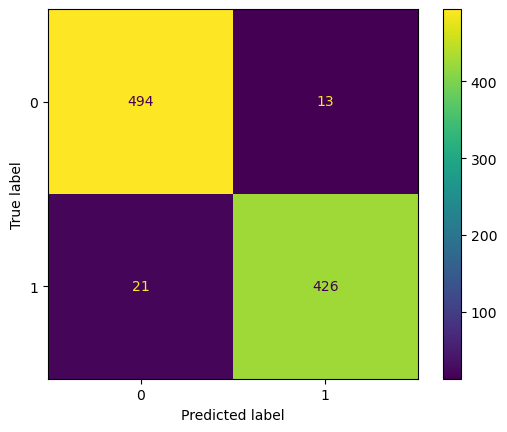

In [231]:
import numpy as np
import matplotlib.pyplot as plt
classes = np.unique(y_test)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes).plot()
plt.show()

In [227]:
from sklearn.metrics import roc_auc_score

In [228]:
roc_auc_score(y_test, y_pred)

0.971756029499701

In [229]:
from sklearn.metrics import roc_curve

In [221]:
print(confusion_matrix(y_test, y_pred))

[[504  15]
 [ 12 423]]


In [222]:
print(accuracy_score(y_test, y_pred))

0.9716981132075472


## Save model and vectorizer to cloud bucket

In [232]:
from google.cloud import storage

In [ ]:
import pickle
pickle.dump(cv, open('cvVectorizer.pkl', 'wb'))
pickle.dump(mnb, open('mnbModel.pkl', 'wb'))

In [223]:
bucket_name = 'spam-detection-data-bucket'
file_name = 'cvVectorizer.pkl'

In [224]:
# Serialize and save the pickled model to a file
with open(file_name, 'wb') as file:
    pickle.dump(cv, file)

# Create a client to access your Google Cloud Storage
client = storage.Client()

# Get the bucket
bucket = client.get_bucket(bucket_name)

# Create a blob (file) in the bucket
blob = bucket.blob(file_name)

# Upload the pickled model file to the blob
blob.upload_from_filename(file_name)

In [225]:
bucket_name = 'spam-detection-data-bucket'
file_name = 'mnbModel.pkl'

In [226]:
# Serialize and save the pickled model to a file
with open(file_name, 'wb') as file:
    pickle.dump(mnb, file)

# Create a client to access your Google Cloud Storage
client = storage.Client()

# Get the bucket
bucket = client.get_bucket(bucket_name)

# Create a blob (file) in the bucket
blob = bucket.blob(file_name)

# Upload the pickled model file to the blob
blob.upload_from_filename(file_name)